# This file is for evaluation of models and visualize images

This implementation is for AU-AIR dataset which is for aerial object detection.

The dataset download link is: [AU-AIR](https://bozcani.github.io/auairdataset)

In this file, we have already train the model with faster-rcnn and use pretrain model weights on MSCOCO.

## 1. Import some libraries

In this evaluation experiment, we use the libraries list is blow:

- pytorch and torchvision
- matplotlib: It is for drawing some pictures.
- tqdm: It is a lib for process bar.

In [1]:
import torch
import torchvision
import numpy as np
from tqdm import tqdm
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
from torch.utils import data

## 2. Import custom classes and functions

In [2]:
from dataset.auairData import AuairData
from utils.eval_detection import eval_detection
from utils.tools import collate_fn

## 3. Load the GPU/CUDA device if it is available

In [3]:
device = torch.device('cpu')
if torch.cuda.is_available():
   device = torch.device('cuda:0')

print(device)

cuda:0


## 4. Define some variables

- classes: AU-AIR dataset labels, it has 8 classes. <font color='blue'>Please don't change it.</font>
- debug: True or False. It can control whether this function is for debug, If it true, some information can print.

In [5]:
classes = ["Human","Car","Truck","Van","Motorbike","Bicycle","Bus","Trailer"]
debug = False

## 5. Load Test Data Set

In the train process, we have already split the dataset. So we can just use the test set path. But if you don't have it, please use the **split_data(original_dir, train_dir, test_dir, log, proportion)** function from utils/tools.py to split the dataset.

- original_dir: It is the path of the original dataset. (The forder of the path should be include the 'Image' forder and 'annotations.json'). Example: '/home/fanfu/newdisk/dataset/705/auair/'
- train_dir: It is a path which is collecting the **train set**. Example: '/home/fanfu/newdisk/dataset/705/auair/train/'
- test_dir: It is a path which is collecting the **test set**. Example: '/home/fanfu/newdisk/dataset/705/auair/test/'
- proportion: It is split percentage which is the number of train set / the total number of data. Example: 0.8

Then we should use the test path the build the dataloader from pytorch.

In [6]:
def load_data(test_dir, labels, batch_size=1, shuffle=False, num_workers=4, debug=False):
    test_dir = '/home/fanfu/newdisk/dataset/705/auair/test/' # This is the test set path that I have already split.
    auair_test_args = {
        'img_dir': test_dir + 'images/',
        'label_dir': test_dir + 'annotations.json',
        'auair_classes': labels,
        'debug': debug
    }
    test_data = AuairData(**auair_test_args)
    dataloader_args = {'batch_size': batch_size, 'shuffle': shuffle, 'num_workers': num_workers, 'collate_fn': collate_fn}
    test_loader = data.DataLoader(test_data, **dataloader_args)
    return test_data, test_loader

In [8]:
test_dir = '/home/fanfu/newdisk/dataset/705/auair/test/' # This is the test set path that I have already split.
test_data, test_loader = load_data(test_dir, classes)

Loading annotations into memory...
Done (t=0.25s)
6564 annotated frames are found.
Checking images...
6564 image files found.


### 5.1 Visualize one of the data
We can use the **visualize_bbox(self, img, bboxes, classes)** from dataset.AuairData Object to visualize the images with bboxes.

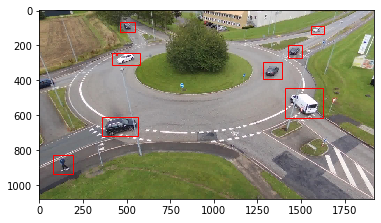

In [7]:
idx, image, ann = test_data.__getitem__(1)
image = image.numpy().transpose((1,2,0))
test_data.visualize_bbox(image, ann['boxes'], ann['labels'])

## 6. Load model and evaluation
In this experiment, we use the **pre-train model from torchvision on MSCOCO** and the backbone is **ResNet50**. Besides, we use **avarage precision (AP)** and **mean avarage precision (MAP)** to evaluate the model. 

The evaluation_func can be used for evaluation.
- model: It is the model which need to evaluate for object detection.
- dataloader: It is the dataset for test.
- iou_thresh: It is thresh for iou computing.

In [8]:
def evaluation_func(model, dataloader, iou_thresh=0.5):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels = list(), list()
    for i, batch in tqdm(enumerate(dataloader)):
        idx, X, y = batch
        if device == torch.device('cuda:0'):
            X, y['labels'], y['boxes'] = X.to(device), y['labels'].to(device), y['boxes'].to(device)
        prediction = model(X)
#         for label in prediction[0]['labels']:
#             if label == 1:
#                 ann = test_data.getImageInformation(idx)
#                 log.logger.info('label is human, the image name is : {}'.format(ann['image_name']))
#                 break
        # if (prediction[0]['labels'])
        gt_bboxes += list(y['boxes'].cpu().numpy())
        gt_labels += list(y['labels'].cpu().numpy())
        pred_bboxes.append(prediction[0]['boxes'].cpu().numpy())
        pred_labels.append(prediction[0]['labels'].cpu().numpy())
        pred_scores.append(prediction[0]['scores'].cpu().numpy())

    result = eval_detection(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, None, iou_thresh=0.5,
        use_07_metric=False
    )
    return result

### 6.1 Pre-train model
This model is pre-train model from torchvision on MSCOCO.

In [9]:
pre_train_weight_dir='model/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth'
frcnn_args = {'rpn_nms_thresh': 0.8, 'num_classes': len(classes)}
pre_train_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, **frcnn_args)
if device == torch.device('cuda:0'):
    pre_train_model = pre_train_model.to(device)
print(pre_train_model)

# load the weight form pre-train model
weights = torch.load(pre_train_weight_dir)
for _n, par in pre_train_model.named_parameters():
    if _n in weights.keys():
        if _n.startswith("roi_heads.box_predictor."):
            par.requires_grad = False
        else:
            par.requires_grad = False
            par.copy_(weights[_n])

pre_train_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

Evaluation this model by MAP and set the iou thresh as 0.5 which is normal value for object detection.

In [10]:
result = evaluation_func(pre_train_model, test_loader, 0.5)
ap = result['ap']
for i in range(0, len(classes)):
    ap_one_class = ap[i]
    class_label = classes[i]
    print("Class name: {}, AP: {}".format(class_label, ap_one_class))
print("Final MAP: {}".format(result['map']))

6564it [08:29, 12.88it/s]


Class name: Human, AP: 0.0
Class name: Car, AP: 0.0014533724729853237
Class name: Truck, AP: 8.255399642877527e-06
Class name: Van, AP: 5.217627194156801e-06
Class name: Motorbike, AP: 0.0
Class name: Bicycle, AP: 3.377374294128772e-06
Class name: Bus, AP: 0.0011832396396169583
Class name: Trailer, AP: 4.7590876097238786e-05
Final MAP: 0.0003376316737288355


In this model, we can see that the MAP is really low and some classes did not detect the objects, like human, car and motorbike.

### 6.2 The first trained model
This model is based on pre-train model and train the last layer for AU-AIR dataset.
The hyper-parameters are:
- learning rate: 0.001
- Weight decay: 0.001
- momentum: 0.9
- epoch: 10
- batch size: 1
- optimizer: SGD

Now firstly, the loss figure should be show. We save the loss from every epoch in log file. Then we copy it from the log file to this and show the line chart.

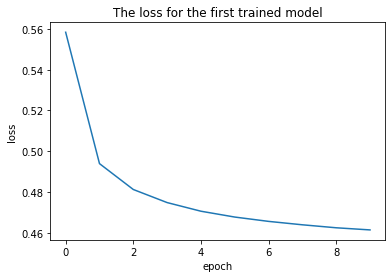

In [11]:
epoch_loss_list=[0.5584065914154053, 0.4939177334308624, 0.48121196031570435, 0.4747939705848694, 0.4705513119697571, 0.4676866829395294, 0.4655628502368927, 0.46388667821884155, 0.46242377161979675, 0.4613737165927887]
plt.plot(epoch_loss_list)
plt.title('The loss for the first trained model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

On this piture, we can see that the loss seem not reach the lowest point, it means that maybe the number epochs of train is not enough. Then we change the number of epoch to 50, add the learning rate decay for every epoch and change the batch size to 8.

The hyper-parameters are:
- learning rate: 0.001
- Weight decay: 0.001
- momentum: 0.9
- epoch: 50
- batch size: 8
- optimizer: SGD
- lr policy: Use stepLR from torch and set the step size as 1 and gammar as 0.99, it means that the learning rate will multiply 0.99 after every epoch.

Then we can get the loss list from the log file which named 'train_log_lrStep.log' and  show the loss line chart.

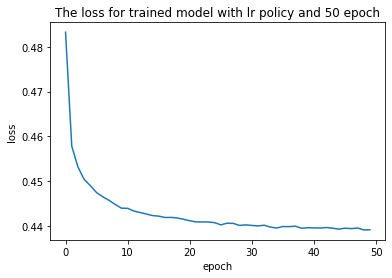

In [12]:
epoch_loss_list=[0.48325392603874207, 0.4578331708908081, 0.45318156480789185, 0.450396329164505, 0.4490059018135071, 0.44745388627052307, 0.4465310275554657, 0.4457319974899292, 0.44481515884399414, 0.44398418068885803, 0.44394928216934204, 0.44334161281585693, 0.4430139660835266, 0.4426911175251007, 0.44233813881874084, 0.44220349192619324, 0.4419054388999939, 0.4419252872467041, 0.4417893588542938, 0.4415069818496704, 0.4411821663379669, 0.4409158527851105, 0.4409097731113434, 0.4408925771713257, 0.44075095653533936, 0.44025909900665283, 0.44063082337379456, 0.44059044122695923, 0.440129816532135, 0.4402528405189514, 0.4401286840438843, 0.4400302767753601, 0.4401783049106598, 0.43974900245666504, 0.43955618143081665, 0.43988680839538574, 0.439868688583374, 0.4399586617946625, 0.4394993185997009, 0.43961796164512634, 0.4395766258239746, 0.4395533800125122, 0.4396643340587616, 0.439515084028244, 0.439301073551178, 0.4395259916782379, 0.439413458108902, 0.43956100940704346, 0.43913108110427856, 0.4391576945781708]
plt.plot(epoch_loss_list)
plt.title('The loss for trained model with lr policy and 50 epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

From this chart, the model seem like normal and better than last one. 

So we can use this model for evaluation.

In [13]:
first_trained_weight_dir='model/model_weight_epoch50_lrStep.pth'
frcnn_args = {'rpn_nms_thresh': 0.8, 'num_classes': len(classes)}
first_trained_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, **frcnn_args)
if device == torch.device('cuda:0'):
    first_trained_model = first_trained_model.to(device)
print(first_trained_model)

# load the weight form trained weith
weights = torch.load(first_trained_weight_dir)
for _n, par in first_trained_model.named_parameters():
    if _n in weights.keys():
        par.requires_grad = False
        par.copy_(weights[_n])

first_trained_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [14]:
result = evaluation_func(first_trained_model, test_loader, 0.5)
ap = result['ap']
for i in range(0, len(classes)):
    ap_one_class = ap[i]
    class_label = classes[i]
    print("Class name: {}, AP: {}".format(class_label, ap_one_class))
print("Final MAP: {}".format(result['map']))

6564it [08:14, 13.28it/s]


Class name: Human, AP: 0.0
Class name: Car, AP: 0.3532134895249923
Class name: Truck, AP: 0.44373540834514286
Class name: Van, AP: 0.31166155298287396
Class name: Motorbike, AP: 0.1016101282880925
Class name: Bicycle, AP: 0.09670423722588369
Class name: Bus, AP: 0.4094048395450912
Class name: Trailer, AP: 0.06297763115328141
Final MAP: 0.22241341088316977


In this model, the result of evaluation is better than pre-train mode and get the 0.23 MAP. But for class human, the AP is 0.0. 

**Analysis**:
We debug this model by predict one image which contained a human object and find that it can not detect this object. We discuss about this situation and guess that the model based on MSCOCO and the class 0 is background. So this model think the class 0 is background and ignore this prediction of human class. (PS: The debug process is not on this jupyter file.)

**Problem**:
The classes don't contain background as 0.

### 6.3 The second Model

This model is for dealing with the problem which human can not be detected on last model.

**The solution**: Add the 'background' to classes as 0 and the index of other classes would be added 1. Then the model structure would be changed to the new number of nodes on last layer as 9.

**PS**: 
1. Keep the hyper-parameters on last model for second model.

We have already trained this model with 9 classes and save the weight as 'model_weight_epoch50_addBG.pth'. Then load this weights to evaluation.

The first thing is that showing the loss chart. The loss is saved on log file which named 'train_log_lrStep_model2.log'.

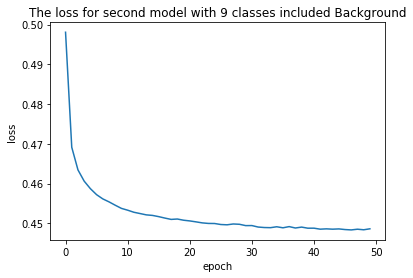

In [15]:
epoch_loss_list = [0.4980696141719818, 0.4691362679004669, 0.4634406864643097, 0.4606141746044159, 0.4587201476097107, 0.457209050655365, 0.45614558458328247, 0.4553992450237274, 0.45455631613731384, 0.45375874638557434, 0.4533079266548157, 0.4527879059314728, 0.45246145129203796, 0.4521309435367584, 0.4519919157028198, 0.4516853094100952, 0.4513210952281952, 0.45099085569381714, 0.45108693838119507, 0.45078542828559875, 0.4506082832813263, 0.4503721594810486, 0.45011597871780396, 0.44997724890708923, 0.44995632767677307, 0.44970354437828064, 0.44963082671165466, 0.44983845949172974, 0.4497610032558441, 0.4494272768497467, 0.44943928718566895, 0.44906967878341675, 0.4489465653896332, 0.44891077280044556, 0.44913771748542786, 0.448879212141037, 0.44917741417884827, 0.4488260746002197, 0.44905489683151245, 0.44877952337265015, 0.44878262281417847, 0.4485321044921875, 0.4486128091812134, 0.44853100180625916, 0.4485982656478882, 0.4484364092350006, 0.4483453035354614, 0.44852277636528015, 0.44838064908981323, 0.4486251473426819]
plt.plot(epoch_loss_list)
plt.title('The loss for second model with 9 classes included Background')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

From this figure, it is similar to last chart of first model.

Because we change the number of classes, so we need to reload the dataset use the new classes list.

Then load the weights which we have already saved and evaluate it.

In [32]:
classes = ["background","Human","Car","Truck","Van","Motorbike","Bicycle","Bus","Trailer"]

print('The length of Classes: {}'.format(len(classes)))

test_data, test_loader = load_data(test_dir, classes)

The length of Classes: 9
Loading annotations into memory...
Done (t=0.16s)
6564 annotated frames are found.
Checking images...
6564 image files found.


In [10]:
second_trained_weight_dir='model/model_weight_epoch50_addBG.pth'
frcnn_args = {'rpn_nms_thresh': 0.8, 'num_classes': len(classes)}
second_trained_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, **frcnn_args)
if device == torch.device('cuda:0'):
    second_trained_model = second_trained_model.to(device)
print(second_trained_model)

# load the weight form trained weith
weights = torch.load(second_trained_weight_dir)
for _n, par in second_trained_model.named_parameters():
    if _n in weights.keys():
        par.requires_grad = False
        par.copy_(weights[_n])

second_trained_model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [18]:
result = evaluation_func(second_trained_model, test_loader, 0.5)
ap = result['ap']
for i in range(1, len(classes)):
    ap_one_class = ap[i]
    class_label = classes[i]
    print("Class name: {}, AP: {}".format(class_label, ap_one_class))
print("Final MAP: {}".format(result['map']))

6564it [08:14, 13.26it/s]


Class name: Human, AP: 0.2216999454630189
Class name: Car, AP: 0.35141515492309106
Class name: Truck, AP: 0.44043023905002365
Class name: Van, AP: 0.3140343742669402
Class name: Motorbike, AP: 0.11763742074265042
Class name: Bicycle, AP: 0.08108259802272119
Class name: Bus, AP: 0.42336321999881965
Class name: Trailer, AP: 0.06386911363567754
Final MAP: 0.25169150826286785


Then we can visualize one image with predicted bounding boxes.

In [17]:
# pick one image from the test set
img = test_data[0]
# print(img[1])
# put the model in evaluation mode
with torch.no_grad():
    prediction = second_trained_model([img[1].to(device)])
    print(prediction[0]["scores"])

tensor([0.9350, 0.8007, 0.4427, 0.2906, 0.2650, 0.2469, 0.2350, 0.2319, 0.2039,
        0.2008, 0.1886, 0.1478, 0.1463, 0.1457, 0.1449, 0.1255, 0.1195, 0.1165,
        0.1087, 0.0994, 0.0927, 0.0838, 0.0819, 0.0816, 0.0654, 0.0646, 0.0618,
        0.0617, 0.0591, 0.0585, 0.0537, 0.0513], device='cuda:0')


torch.Size([3, 1080, 1920])
(1080, 1920, 3)
tensor([0.9350, 0.8007, 0.4427, 0.2906, 0.2650, 0.2469, 0.2350, 0.2319, 0.2039,
        0.2008, 0.1886, 0.1478, 0.1463, 0.1457, 0.1449, 0.1255, 0.1195, 0.1165,
        0.1087, 0.0994, 0.0927, 0.0838, 0.0819, 0.0816, 0.0654, 0.0646, 0.0618,
        0.0617, 0.0591, 0.0585, 0.0537, 0.0513])


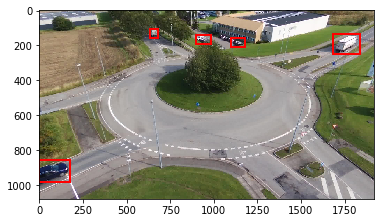

In [22]:
from matplotlib.patches import Rectangle
import numpy 

with torch.no_grad():
    threshold = 0.25

    scores = prediction[0]['scores'].to("cpu")
    bboxes = prediction[0]['boxes'].to("cpu")
    classes_labels = prediction[0]['labels'].to("cpu")
    best_idx = np.where(scores>threshold)
    best_bboxes = bboxes[best_idx]
    best_classes = bboxes[best_idx]

    if len(best_idx)>0:
        print(img[1].shape)
        img_tr = img[1].numpy().transpose((1,2,0))
        print(img_tr.shape)
        plt.imshow(img_tr)
        ax=plt.gca()
        print(scores)
        if best_bboxes.nelement() == 0:
            print("There is no confident bounding boxes.")
        else:
            for b in best_bboxes:
                rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        plt.show()

### 6.4 The custom model

From the architecture, we can see that the faster rcnn from torchvision is not traditional model, it add FeaturePyramidNetwork between backbone and RPN layer. So we try to delete the FPN layer and rewrite the architecture of the network. 

In this experiment, we also use the ResNet50 from torchvision as the backbone and add RPN, RoI layer to build the network. The architecture is below:

TODO: add the architecture.

Based on the last experiment, we keep the pre-build the dataloader and Hyper-parameters to train the new model. The pre-train model of ResNet50 is from torchvision on ImageNet. So in this experiment, we need to train the RPN layer, RoI layer and classification layer.

We have already trained the model on PyCharm and save the weights. So the first thing is checking the loss chart.

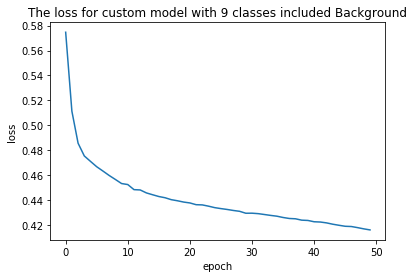

In [23]:
epoch_loss_list_cusmodel = [0.5746091688792225, 0.5114462667672764, 0.4858047744412993, 0.4756244470479101, 0.4712588189852299, 0.4669903073501848, 0.4635506440754021, 0.4600199573366082, 0.45682183047401953, 0.45354576052106665, 0.45274515704178353, 0.44867281032033424, 0.44841976003551715, 0.4460449663696949, 0.44458013591862944, 0.4431682840656878, 0.4421933706653507, 0.44064715651706193, 0.43976665262111325, 0.43872532799063824, 0.43802666239737736, 0.4366317878962652, 0.4364548616435809, 0.4354444191635944, 0.43426520483380515, 0.43349712858322076, 0.43281257807972445, 0.43200259678635405, 0.43133556742494583, 0.42978706398988475, 0.42982616267151996, 0.4294632658829894, 0.4287666193221787, 0.42805482818428203, 0.4274305729805388, 0.426392104021667, 0.4255996191334586, 0.42534933489994997, 0.42425171797173145, 0.42402187066037517, 0.42296854428608827, 0.4227589822481799, 0.4220683289452947, 0.4210092497106155, 0.42015590545719367, 0.41936350303599645, 0.4191602740642177, 0.4182710168594418, 0.4172833244039124, 0.41644558135761633]
plt.plot(epoch_loss_list_cusmodel)
plt.title('The loss for custom model with 9 classes included Background')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In the loss chart, we can see that the 50 epochs are not enough for trainning because we have more parameters and layers which need train than before. But the final loss is simarly to the last loss before. So we can compare firstly.

Same to before, we have already save the weights on model/weight path. 

In [34]:
from model.faster_rcnn.faster_rcnn_res50 import FasterRCNNResNet50
custom_model_weight_path = 'model/weight/fasterrcnn_resnet50_mymodel_epoch40.pth'
custom_frcnn_model = FasterRCNNResNet50(classes, pretrained=False, class_agnostic=False)
custom_frcnn_model.create_architecture()
if device == torch.device('cuda:0'):
    custom_frcnn_model = custom_frcnn_model.to(device)
# log.logger.info('model structure:{}'.format(frcnn_model))

# load the weight form baseline
weights = torch.load(custom_model_weight_path)
for _n, par in custom_frcnn_model.named_parameters():
    if _n in weights.keys():
#         print(_n)
        par.requires_grad = False
        # print(_n)
        par.copy_(weights[_n])
        # par.requires_grad = True
custom_frcnn_model.eval()

The input data to model is a little different with last experiment. So we should pre-process the data from dataloader for fitting model. So we change the evaluation function but also use the same evaluation method.

In [9]:
def evaluation_func_for_cusmodel(model, dataloader, iou_thresh=0.5):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels = list(), list()
    for i, batch in tqdm(enumerate(test_loader)):
        idx, images, targets = batch
        # check whether empty object
        image_list = []
        target_list = []
        for i in range(0, len(targets)):
            # delete some empty data
            if bool(targets[i]['labels'].numel()) and bool(targets[i]['boxes'].numel()):
                target_list.append(targets[i])
                image_list.append(images[i])
            else:
                continue

        target_tuple = tuple(target_list)
        image_tuple = tuple(image_list)
        if len(target_tuple) > 0:
            ####################### Combine the datas to fit model ################################
            # check the max number of bounding box
            max_num_bbox = 0
            for target in target_list:
                if len(target['boxes']) > max_num_bbox:
                    max_num_bbox = len(target['boxes'])
            # combine the data to fit the batch training
            image_info_list = []
            num_boxes_list = []
            gt_boxes_list = []
            # image input data
            if device == torch.device('cuda:0'):
                image_tensor = torch.stack(list(image.to(device) for image in image_tuple))
            else:
                image_tensor = torch.from_numpy(image_tuple)
            # Target input data combination for fit batch training, the input is [N, 5]
            # N: batch size
            # 5: [xmin, ymin, xmax, ymax, label]
            for i in range(0, image_tensor.size(0)):
                image_info_list.append([image_tensor.size(2), image_tensor.size(3),
                                        image_tensor.size(3) / 1920])  # the final one is scale rate
                gt_box_list = target_tuple[i]['boxes']
                gt_label_list = target_tuple[i]['labels']
                num_boxes_list.append(len(gt_box_list))
                gt_boxes_one = []
                for i in range(0, len(gt_box_list)):
                    gt_box = gt_box_list[i]
                    gt_label = gt_label_list[i]
                    gt_boxes_one.append(
                        torch.stack([gt_box[0], gt_box[1], gt_box[2], gt_box[3], gt_label]).float())
                for i in range(0, max_num_bbox - len(gt_box_list)):
                    # for keep the save dimentions, so we add some additional bounding boxes for background which class is 0.
                    gt_boxes_one.append(torch.from_numpy(np.asarray([0, 0, 0, 0, 0])).float())
                gt_boxes_list.append(torch.stack(gt_boxes_one))
            im_info = torch.from_numpy(np.array(image_info_list))
            gt_boxes = torch.stack(gt_boxes_list).to(device)
            num_boxes = np.asarray(num_boxes_list)
            if device == torch.device('cuda:0'):
                im_info = im_info.to(device)
                gt_boxes = gt_boxes.to(device)
            ############################# end Combine data to fit model ################################
            prediction = model(image_tensor, gt_boxes, im_info, num_boxes)
            gt_bboxes.append(target_list[0]['boxes'].numpy())
            gt_labels.append(target_list[0]['labels'].numpy())
            pred_bboxes.append(prediction[0]['boxes'])
            pred_labels.append(prediction[0]['labels'])
            pred_scores.append(prediction[0]['scores'])
            
           
    result = eval_detection(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, None, iou_thresh=0.5,
        use_07_metric=False
    )
    return result

In [12]:
# solve the tensor lager than the size of open files, we can check by 'ulimit -a', the open files is 1024
torch.multiprocessing.set_sharing_strategy('file_system')

result = evaluation_func_for_cusmodel(custom_frcnn_model, test_loader, 0.5)
ap = result['ap']
for i in range(1, len(classes)):
    ap_one_class = ap[i]
    class_label = classes[i]
    print("Class name: {}, AP: {}".format(class_label, ap_one_class))
print("Final MAP: {}".format(result['map']))

6564it [11:42,  9.35it/s]


Class name: Human, AP: 0.18811047743634723
Class name: Car, AP: 0.3360883909327407
Class name: Truck, AP: 0.46218151337409175
Class name: Van, AP: 0.391560096699785
Class name: Motorbike, AP: 0.17220927000103692
Class name: Bicycle, AP: 0.014957933566719645
Class name: Bus, AP: 0.44026759752851324
Class name: Trailer, AP: 0.022558973636036195
Final MAP: 0.25349178164690883


Then we can use this model to visulase one image which contained the prediction bounding boxes.

In [75]:
# pick one image from the test set
img = test_data[1]
# print(img[1])
image_tensor = torch.stack(list(image.to(device) for image in img[1]))
image_tensor = torch.unsqueeze(image_tensor, 0)
# print(image_tensor.shape)
# combine the ground truth and labesl
gt_box_list = img[2]['boxes']
gt_label_list = img[2]['labels']
gt_boxes_one = []
gt_boxes_list = []
for i in range(0, len(gt_box_list)):
    gt_box = gt_box_list[i]
    gt_label = gt_label_list[i]
    gt_boxes_one.append(torch.stack([gt_box[0], gt_box[1], gt_box[2], gt_box[3], gt_label]).float())
gt_boxes = torch.stack(gt_boxes_one).to(device)
# gt_boxes_list.append(torch.stack())

# print(img[1])
# put the model in evaluation mode
with torch.no_grad():
    prediction_cus = custom_frcnn_model(image_tensor, gt_boxes, None, np.asarray([1]))
#     prediction = custom_frcnn_model([img[1].to(device)])
    print(prediction_cus[0]["scores"])

[0.93631196 0.93728584 0.90652043 0.90220422 0.89714336 0.88231796
 0.83031076 0.81923014 0.63600719 0.25975031 0.12715016 0.11853739
 0.05748292 0.05641538 0.05173544 0.15921719 0.82726216 0.05413479
 0.16596922]


[0.93631196 0.93728584 0.90652043 0.90220422 0.89714336 0.88231796
 0.83031076 0.81923014 0.63600719 0.25975031 0.12715016 0.11853739
 0.05748292 0.05641538 0.05173544 0.15921719 0.82726216 0.05413479
 0.16596922]


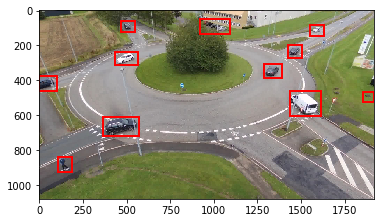

In [78]:
from matplotlib.patches import Rectangle
import numpy 

with torch.no_grad():
    threshold = 0.25

    scores = prediction_cus[0]['scores']
    print(scores)
    bboxes = prediction_cus[0]['boxes']
    classes_labels = prediction_cus[0]['labels']
    best_idx = np.where(scores>threshold)
    best_bboxes = bboxes[best_idx]
#     print(best_bboxes)
    best_classes = bboxes[best_idx]

    if len(best_idx)>0:
#         print(img[1].shape)
        img_tr = img[1].numpy().transpose((1,2,0))
#         print(img_tr.shape)
        plt.imshow(img_tr)
        ax=plt.gca()
#         print(scores)
        if len(best_bboxes) == 0:
            print("There is no confident bounding boxes.")
        else:
            for b in best_bboxes:
                rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        plt.show()

### 6.5 The second custom model

Additional:
1. Compared with the faster rcnn in paper, we can see that our architecture lose a fully connected layer between RoI layer and prediction layer. So we add a fully connected layer before the prediction layer.

2. From the loss chart, we can see that the line didn't reach the loweset point. So in this training process, we large the learning rate to 0.002.

Then we can see that the loss chart:

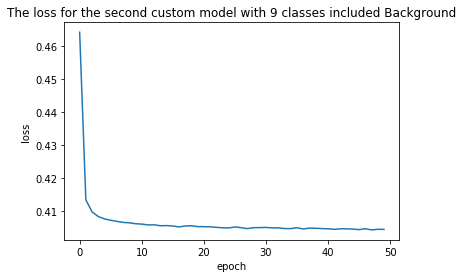

In [10]:
epoch_loss_list_cusmodel2 = [0.4641248142704744, 0.41328556796163096, 0.40963034042217655, 0.4082182118515397, 0.4074910991381771, 0.4070878465828139, 0.40674490311633804, 0.40643488264214583, 0.4063248036794099, 0.40603533590072327, 0.4059285465905915, 0.4056697205467047, 0.405712615152775, 0.40542482486448017, 0.40547196908382754, 0.40535155964032055, 0.4050623292544249, 0.4053514632162364, 0.40542048251723284, 0.4051644477290857, 0.40514796974090334, 0.4050878663588471, 0.40494787167420737, 0.40479221871957305, 0.4047669581649073, 0.4050573388269461, 0.4048321936285209, 0.4045421466154185, 0.404839864662788, 0.4048575090764682, 0.4049141912599399, 0.40476474634783316, 0.4047754156382535, 0.40456520301918775, 0.40455230630246597, 0.40483095577912037, 0.4044308948092006, 0.40470854354783453, 0.4046690365299015, 0.4045561988098462, 0.40450567062439224, 0.4043422943475295, 0.40449939079485103, 0.4044968912759787, 0.40440756570918873, 0.40424735018058117, 0.40452356617460883, 0.4041589594426549, 0.4043543096489925, 0.4043138476404663]
plt.plot(epoch_loss_list_cusmodel2)
plt.title('The loss for the second custom model with 9 classes included Background')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Result: We can see that maybe the lr is a little big so that the decrease of loss is so quick.

Then we can evaluate this model.

In [11]:
from model.faster_rcnn.faster_rcnn_res50 import FasterRCNNResNet50
custom_model2_weight_path = 'model/weight/2/fasterrcnn_resnet50_mymodel2.pth'
custom_frcnn_model2 = FasterRCNNResNet50(classes, pretrained=False, class_agnostic=False)
custom_frcnn_model2.create_architecture()
if device == torch.device('cuda:0'):
    custom_frcnn_model2 = custom_frcnn_model2.to(device)
# log.logger.info('model structure:{}'.format(frcnn_model))

# load the weight form baseline
weights = torch.load(custom_model2_weight_path)
for _n, par in custom_frcnn_model2.named_parameters():
    if _n in weights.keys():
        par.requires_grad = False
        # print(_n)
        par.copy_(weights[_n])
        # par.requires_grad = True
custom_frcnn_model2.eval()

In [14]:
# solve the tensor lager than the size of open files, we can check by 'ulimit -a', the open files is 1024
torch.multiprocessing.set_sharing_strategy('file_system')

result = evaluation_func_for_cusmodel(custom_frcnn_model2, test_loader, 0.5)
ap = result['ap']
for i in range(1, len(classes)):
    ap_one_class = ap[i]
    class_label = classes[i]
    print("Class name: {}, AP: {}".format(class_label, ap_one_class))
print("Final MAP: {}".format(result['map']))

6564it [11:47,  9.28it/s]


Class name: Human, AP: 0.18708990162418382
Class name: Car, AP: 0.32363427091604546
Class name: Truck, AP: 0.46235722520598016
Class name: Van, AP: 0.40096818849900495
Class name: Motorbike, AP: 0.08374016227178874
Class name: Bicycle, AP: 0.02108561221769378
Class name: Bus, AP: 0.4405571035678749
Class name: Trailer, AP: 0.027601177209214182
Final MAP: 0.24337920518897324


For this result, we can see that the MAP is not better than before. We guess the reason:
1. The learning rate is a litter large so that the features which the model learned is not complete.

The solution:
In next module, we change the learning rate to 0.0015 which is less than 0.002 and bigger than 0.001.

Change the batch-size to 6 because we have additional parameters for relation module, so we need more GPU memory. So we need to decrease the batch size for fit the total GPU memory.

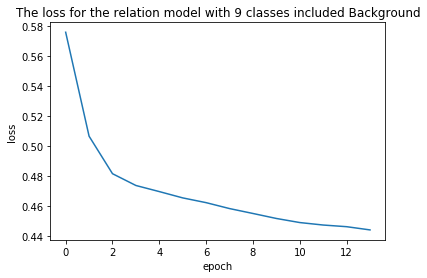

In [80]:
epoch_loss_list_relation = [0.5758962950471331, 0.5067168502796722, 0.4817553398292299, 0.4739112974756652, 0.469847622342402, 0.46565308708410996, 0.46248238339100917, 0.45854385474644266, 0.4552804700014524, 0.4519578511319538, 0.4492391575317935, 0.447592376822837, 0.44648895430841795, 0.4443420358257537]
plt.plot(epoch_loss_list_relation)
plt.title('The loss for the relation model with 9 classes included Background')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [23]:
from model.faster_rcnn.faster_rcnn_res50 import FasterRCNNResNet50
relation_model2_weight_path = 'model/weight/relation/fasterrcnn_resnet50_mymodel2.pth'
custom_relation_model2 = FasterRCNNResNet50(classes, pretrained=False, class_agnostic=False)
custom_relation_model2.create_architecture()
if device == torch.device('cuda:0'):
    custom_relation_model2 = custom_relation_model2.to(device)
# log.logger.info('model structure:{}'.format(frcnn_model))

# load the weight form baseline
weights = torch.load(relation_model2_weight_path)
for _n, par in custom_relation_model2.named_parameters():
    if _n in weights.keys():
        par.requires_grad = False
        # print(_n)
        par.copy_(weights[_n])
        # par.requires_grad = True
custom_relation_model2.eval()

In [28]:
# solve the tensor lager than the size of open files, we can check by 'ulimit -a', the open files is 1024
torch.multiprocessing.set_sharing_strategy('file_system')

result = evaluation_func_for_cusmodel(custom_relation_model2, test_loader, 0.5)
ap = result['ap']
for i in range(1, len(classes)):
    ap_one_class = ap[i]
    class_label = classes[i]
    print("Class name: {}, AP: {}".format(class_label, ap_one_class))
print("Final MAP: {}".format(result['map']))

6564it [11:38,  9.39it/s]


Class name: Human, AP: 0.0399672269903328
Class name: Car, AP: 0.2863813290933687
Class name: Truck, AP: 0.38588176024186005
Class name: Van, AP: 0.3468282599397019
Class name: Motorbike, AP: 0.0
Class name: Bicycle, AP: 0.0
Class name: Bus, AP: 0.3607458153585733
Class name: Trailer, AP: 0.017099300154819058
Final MAP: 0.179612961472332
